<a href="https://colab.research.google.com/github/varunyadav17/SoyaBeanWeedNeuralNetwork/blob/master/SoyaCropNeuralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
import glob
import zipfile

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (19.0, 17.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
os.environ['KAGGLE_USERNAME'] = "varunyadav17"
os.environ['KAGGLE_KEY'] = "2073c7a8d526d9d351df6f8f499e6080"
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

100% 2.36G/2.37G [00:44<00:00, 30.2MB/s]
100% 2.37G/2.37G [00:44<00:00, 57.4MB/s]


In [0]:
with zipfile.ZipFile('/content/weed-detection-in-soybean-crops.zip') as zipRef:
  zipRef.extractall('.')

In [9]:
import shutil
os.chdir('dataset')
print(os.getcwd())
if os.path.exists('dataset'):
  shutil.rmtree('dataset')
os.chdir('..')

/content/dataset


In [0]:
classes = os.listdir('dataset')
no_of_classes = len(classes)
samples_per_class = 4

In [12]:
num_file = 1100
all_files = []
num_data = num_file * len(classes)
Y = np.zeros(num_data)

for i, cls in enumerate(classes):
  all_files += [f for f in glob.glob('dataset/' + cls + '/*.tif')] [:num_file]
  Y[i * num_file:(i + 1) * num_file] = i
  
img_width = 200
img_height = 200
img_channel = 3
dim = img_width * img_height * img_channel

X = np.ndarray(shape = (num_data, img_width, img_height, img_channel), dtype = np.float64)

for idx, file in enumerate(all_files):
  X[idx] = cv2.resize(cv2.imread(file), (img_width, img_height))
  
X_train = np.empty(shape = (5000, img_width, img_height, img_channel), dtype = np.float64)
X_val = np.empty(shape = (250, img_width, img_height, img_channel), dtype = np.float64)
X_test = np.empty(shape = (250, img_width, img_height, img_channel), dtype = np.float64)

Y_train = np.empty(5000)
Y_val = np.empty(250)
Y_test = np.empty(250)

for i, cls in enumerate(classes):  
  X_test[50*i:50*(i + 1)] = X[np.where(Y == i)[0][:50]]
  X_val[50*i:50*(i + 1)] = X[np.where(Y == i)[0][50:100]]
  X_train[1000*i:1000*(i + 1)] = X[np.where(Y == i)[0][100:]]
  
  Y_test[50*i:50*(i + 1)] = i
  Y_val[50*i:50*(i + 1)] = i
  Y_train[1000*i:1000*(i + 1)] = i
  
del Y
del X

train_idxs = np.random.permutation(X_train.shape[0])
Y_train = Y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
Y_tiny = Y_train[100:110].astype(int)

num_dev = 500

X_dev = X_train[0:num_dev].astype('float64')
Y_dev = Y_train[0:num_dev].astype(int)

print("X_train shape", X_train.shape, " Y_train shape:", Y_train.shape)
print("X_test shape", X_test.shape, "Y_test shape:", Y_test.shape)
print("X_val shape", X_val.shape, " Y_val shape:", Y_val.shape)
print("X_dev shape", X_dev.shape, " Y_dev shape:", Y_dev.shape)
print("X_tiny shape", X_tiny.shape, " Y_tiny shape:", Y_tiny.shape)

mean_image = 128

X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

X_train shape (5000, 120000)  Y_train shape: (5000,)
X_test shape (250, 120000) Y_test shape: (250,)
X_val shape (250, 120000)  Y_val shape: (250,)
X_dev shape (500, 120000)  Y_dev shape: (500,)
X_tiny shape (10, 120000)  Y_tiny shape: (10,)


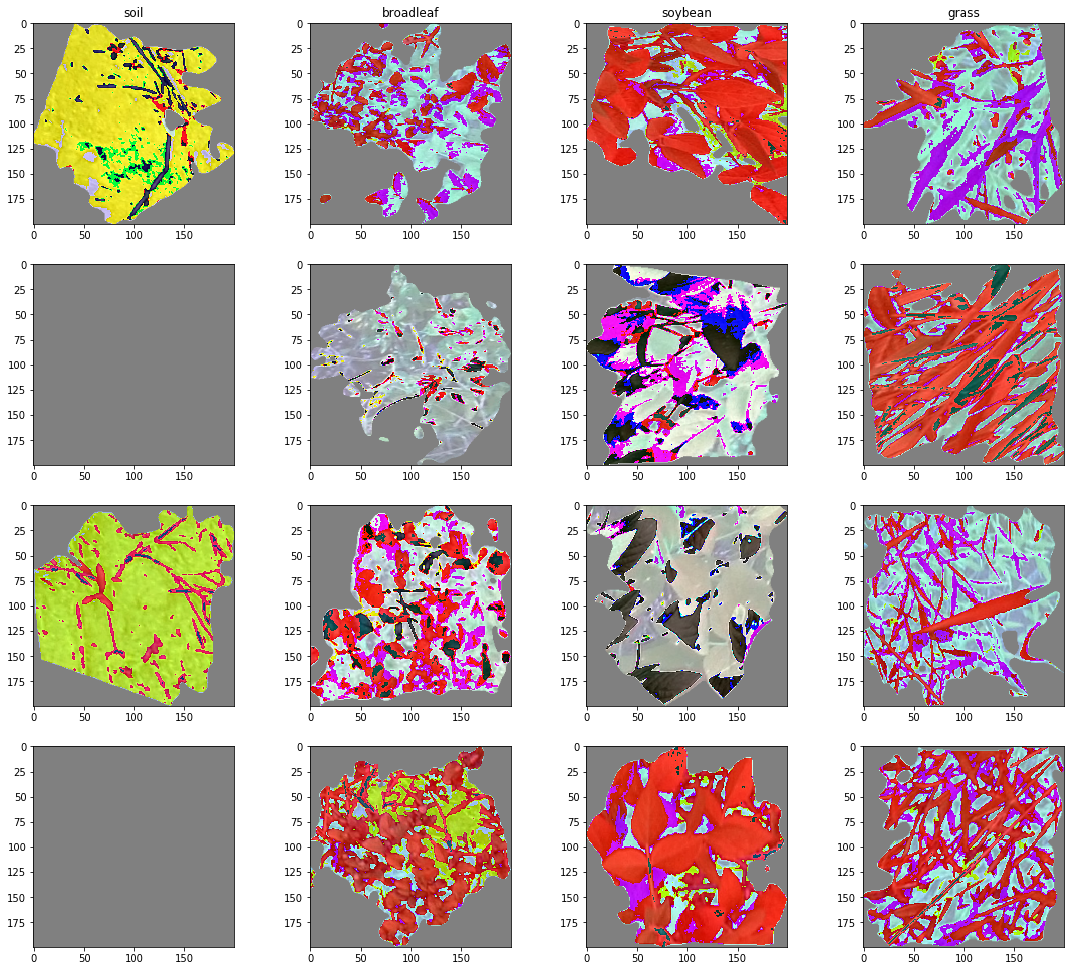

In [13]:
for y, cls in enumerate(classes):
  idxes = np.flatnonzero(y == Y_train)
  idxes = np.random.choice(idxes, samples_per_class, replace = False)
  for i, idx in enumerate(idxes):
    plt_idx = i * no_of_classes + y + 1
    plt.subplot(samples_per_class, no_of_classes, plt_idx)
    plt.imshow(X_train[idx].reshape(img_width, img_height, img_channel).astype('uint8'))
    if i == 0:
      plt.title(cls)
      
plt.show()

In [0]:
class TwoLayerNet():
  def __init__(self, input_size, hidden_size, output_size, std = 1e-4):
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)
    
  def loss(self, X, y = None, reg = 0.0):
    # Define relu
    relu = lambda x:np.maximum(0, x)
    
    # Unpack
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape
    
    # Forward Propagation
    layer1 = relu(X.dot(W1) + b1)
    scores = layer1.dot(W2) + b2
    
    # No target then jump out 
    if y is None:
      return scores
   
    scores -= scores.max()
    
    scores = np.exp(scores)
    scores_sumexp = np.sum(scores, axis = 1)
    
    # Normalize scores
    softmax = scores / scores_sumexp.reshape(N, 1)
    
    # Total loss of all training
    loss = (-1.0) * np.sum(np.log(softmax[range(N), y]))
    
    # Normalize the loss and add regularization strength
    loss /= N
    loss += reg * np.sum(W1 * W1)
    loss += reg * np.sum(W2 * W2)
    
    # Backward pass on the net
    grads = {}
    
    correct_classes_scores = scores[range(N), y]
    softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_classes_scores) / scores_sumexp
    softmax /= N
    
    grads['W2'] = layer1.T.dot(softmax)
    grads['b2'] = np.sum(softmax, axis = 0)
    grads['W2'] += reg * 2 * W2
    
    hidden = softmax.dot(W2.T)
    
    hidden[layer1 == 0] = 0
    
    grads['W1'] = X.T.dot(hidden)
    grads['b1'] = np.sum(hidden, axis = 0)
    grads['W1'] += reg * 2 * W1
    
    return loss, grads
  
  def train(self, X, y, X_val, y_val, learning_rate = 1e-3, learning_rate_decay = 0.95, reg = 5e-6, num_iters = 100, batch_size = 200, it_verbose = 1, verbose = False):
    N, D = X.shape
    N_val = X_val.shape[0]
    iteration_per_epoch = max(N/batch_size, 1)
    
    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    
    for it in range(num_iters):
      sampling = np.random.choice(np.arange(N), batch_size, replace = False)
      X_batch = X[sampling]
      Y_batch = y[sampling]
      
      # Compute loss and gradients
      loss, grads = self.loss(X_batch, y = Y_batch, reg = reg)
      loss_hist.append(loss)
      
      # Update rule
      self.params['W1'] += (-1.0) * learning_rate * grads['W1']
      self.params['b1'] += (-1.0) * learning_rate * grads['b1']
      self.params['W2'] += (-1.0) * learning_rate * grads['W2']
      self.params['b2'] += (-1.0) * learning_rate * grads['b2']
      
      if verbose and it % it_verbose == 0:
        print("Iteration: %d / %d | Loss: %f" % (it, num_iters, loss))
        
      if it % iteration_per_epoch == 0:
        train_acc = (self.predict(X_batch) == Y_batch).mean()
        val_acc = (self.predict(X_val) == Y_val).mean()
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)
        
        # Decay learning rate
        learning_rate *= learning_rate_decay
        
    return{
       'loss_hist': loss_hist,
       'train_acc_hist': train_acc_hist,
       'val_acc_hist': val_acc_hist
    }
  
  def predict(self, X):
    y_pred = None
    relu = lambda x : np.maximum(0, x)
    
    # Unpack variables from params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    
    # Forward propagation through the network
    layer1 = relu(X.dot(W1) + b1)
    scores = layer1.dot(W2) + b2
    y_pred = np.argmax(scores, axis = 1)
    
    return y_pred

In [15]:
input_size = img_width * img_height * img_channel
hidden_size = 200
output_size = no_of_classes
std = 1e-3

net = TwoLayerNet(input_size, hidden_size, output_size, std)
stats = net.train(X_dev, Y_dev, X_val, Y_val, learning_rate = 1e-5, learning_rate_decay = 0.95, reg = 0.0, num_iters = 70, batch_size = 100, it_verbose = 10, verbose = True)

Iteration: 0 / 70 | Loss: 1.356343
Iteration: 10 / 70 | Loss: 1.161735
Iteration: 20 / 70 | Loss: 1.126031
Iteration: 30 / 70 | Loss: 1.152670
Iteration: 40 / 70 | Loss: 1.083330
Iteration: 50 / 70 | Loss: 1.008018
Iteration: 60 / 70 | Loss: 1.028588


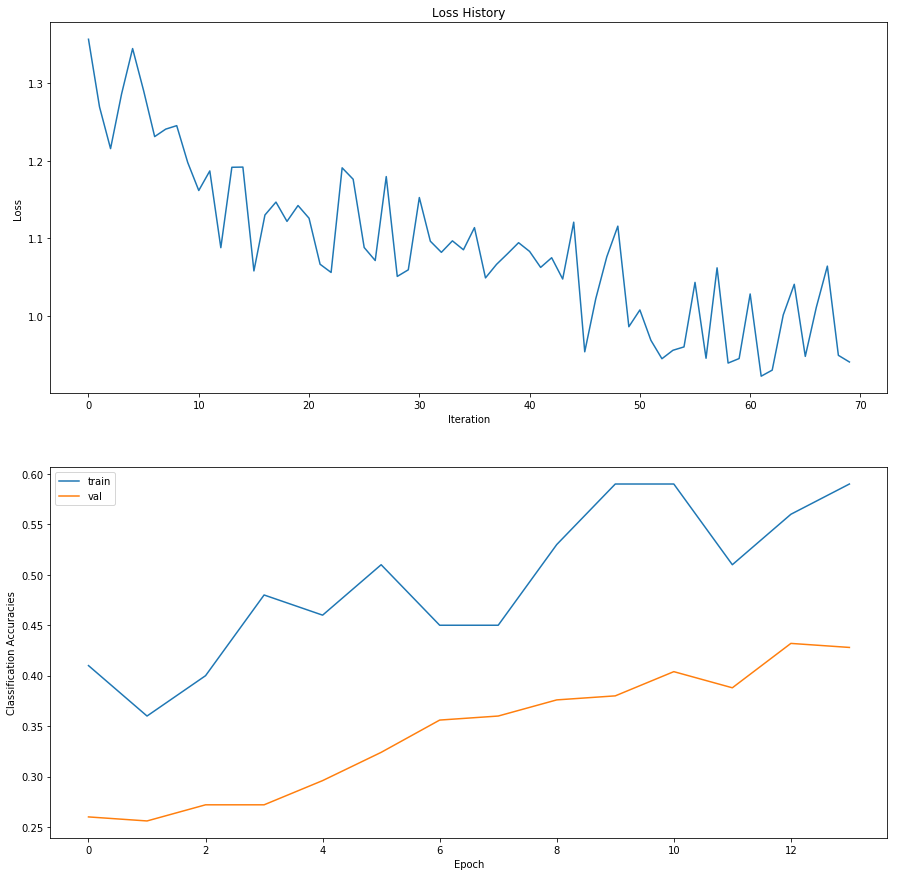

In [16]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplot(2, 1, 1)
plt.plot(stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_hist'], label = 'train')
plt.plot(stats['val_acc_hist'], label = 'val')
plt.xlabel('Epoch')
plt.ylabel('Classification Accuracies')
plt.legend()
plt.show()

In [17]:
print((net.predict(X_test) == Y_test).mean())

0.412


**Hyperparameter Search**

In [19]:
best_net = None
best_val = -1

hidden_units = [200]
learn_rates = [7.6e-5]
regularizations = [0.0]
iterations = [600]

result = {}
best_stats = None

input_size = img_height * img_width * img_channel
output_size = 4

for hidden in hidden_units:
  for learn in learn_rates:
    for r in regularizations:
      for iter in iterations:
        tune_net = TwoLayerNet(input_size, hidden_size = hidden, output_size = output_size, std = 1e-3)
        stats = tune_net.train(X_train, Y_train, X_val, Y_val, num_iters = iter, batch_size = 200, learning_rate = learn, learning_rate_decay = 0.94, reg = r, it_verbose = 100, verbose = True)
        train_acc = stats['train_acc_hist'][-1]
        val_acc = stats['val_acc_hist'][-1]
        result[(hidden, learn)] = (train_acc, val_acc)
        print('hs:',hidden,'learn:',learn,'reg',r,'iter',iter,'train-acc:',train_acc,'val_acc',val_acc)
        
        if val_acc > best_val:
          best_val = val_acc
          best_stats = stats
          best_net = tune_net
          
        del tune_net
        del stats
        
print("Accuracy on Test set", (best_net.predict(X_test) == Y_test).mean())

Iteration: 0 / 600 | Loss: 1.367721
Iteration: 100 / 600 | Loss: 0.657938
Iteration: 200 / 600 | Loss: 0.538872
Iteration: 300 / 600 | Loss: 0.476834
Iteration: 400 / 600 | Loss: 0.389322
Iteration: 500 / 600 | Loss: 0.375450
hs: 200 learn: 7.6e-05 reg 0.0 iter 600 train-acc: 0.865 val_acc 0.66
Accuracy on Test set 0.572


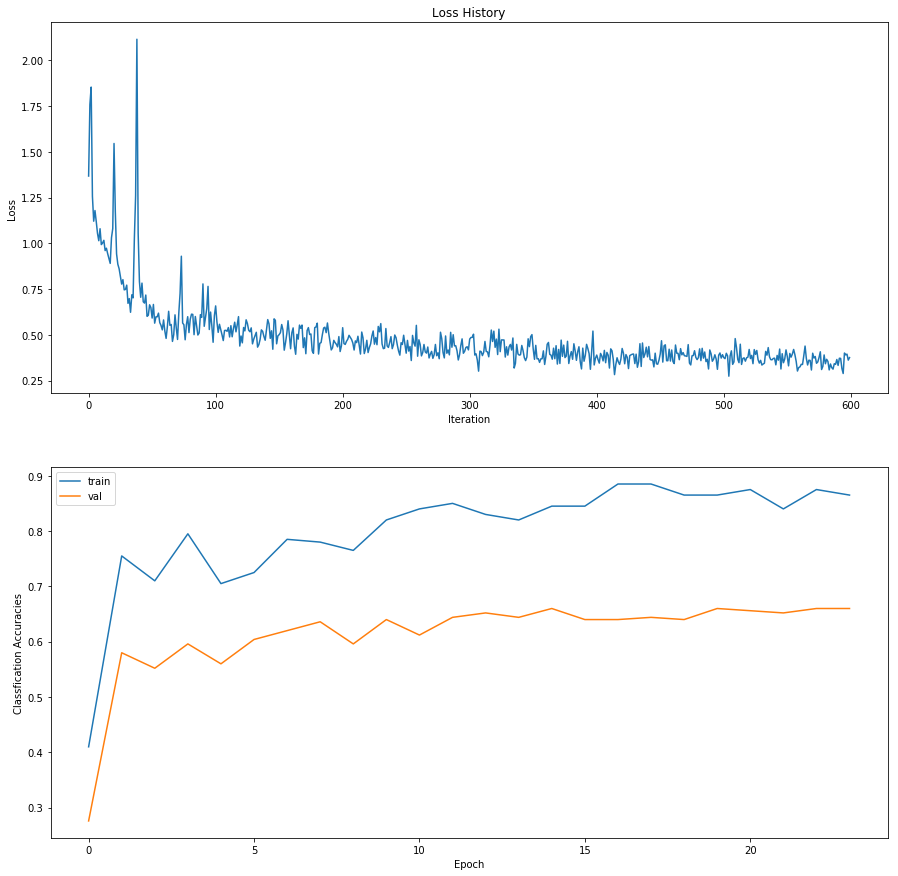

In [20]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(best_stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(best_stats['train_acc_hist'], label='train')
plt.plot(best_stats['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()